# IMDb Movie Success Prediction: A Multi-Class Classification Approach

### **1. Executive Summary**
The film industry is a high-risk environment where predicting audience reception can significantly reduce financial uncertainty. This project aims to build a **Classification Model** to predict a movie's success tier (**Low**, **Medium**, **High**) based on pre-release metadata and audience engagement signals.

**Objectives:**
1.  **Data Integration:** Merge relational IMDb datasets (`basics`, `ratings`, `akas`) into a unified analytical view.
2.  **Smart Sampling:** Utilize **Stratified Sampling** to create a representative dataset of 100,000 titles, preserving the real-world distribution of movie types while ensuring computational efficiency.
3.  **Feature Engineering:** Transform raw metadata into high-signal predictors (e.g., **One-Hot Encoding** for genres).
4.  **Model Comparison:** Evaluate three distinct algorithms—**Logistic Regression**, **Decision Tree**, and **Random Forest**—to determine which best captures the complex drivers of movie success.
5.  **Interpretation:** Move beyond accuracy scores to understand *why* a movie succeeds using **Feature Importance** and **Confusion Matrix** analysis.

In [46]:
import os
import pandas as pd
import numpy as np
import kagglehub
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Visualization Settings
sns.set(style="whitegrid", context="notebook", palette="muted")
print("Libraries Loaded Successfully")

Libraries Loaded Successfully


In [47]:
path = kagglehub.dataset_download("vivekananda99/imdb-dataset")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/imdb-dataset


In [48]:
for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = " " * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

imdb-dataset/
    title.basics.tsv
    title.episode.tsv
    title.principals.tsv
    title.ratings.tsv
    name.basics.tsv
    title.akas.tsv
    title.crew.tsv


In [49]:
con = duckdb.connect(database=':memory:')

# Register CSVs as DuckDB tables using nullstr for '\N'
con.execute(f"""
    CREATE TABLE basics AS 
    SELECT * FROM read_csv_auto(
        '{os.path.join(path, "title.basics.tsv")}', 
        nullstr='\\N',
        header=True,
        sep='\t'
    )
""")

con.execute(f"""
    CREATE TABLE akas AS 
    SELECT * FROM read_csv_auto(
        '{os.path.join(path, "title.akas.tsv")}', 
        nullstr='\\N',
        header=True,
        sep='\t'
    )
""")

con.execute(f"""
    CREATE TABLE ratings AS 
    SELECT * FROM read_csv_auto(
        '{os.path.join(path, "title.ratings.tsv")}', 
        nullstr='\\N',
        header=True,
        sep='\t'
    )
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
query = """
    SELECT 
        b.tconst,
        b.titleType,
        b.isAdult,
        b.startYear,
        b.genres,
        a.region,
        r.averageRating,
        r.numVotes
    FROM basics b
    JOIN ratings r
        ON b.tconst = r.tconst
    LEFT JOIN akas a
        ON b.tconst = a.titleId
    WHERE b.startYear IS NOT NULL
      AND r.averageRating IS NOT NULL
"""

df = con.execute(query).df()
print("Merged dataset shape:", df.shape)
df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:
df.isnull().sum()

tconst                 0
titleType              0
isAdult                0
startYear              0
genres             63863
region           1685498
averageRating          0
numVotes               0
dtype: int64

## 2. Feature Engineering & Stratified Sampling
To prepare our data for modeling, we need to:
1.  **Handle Missing Values:** We impute missing regions and genres with "Unknown" or "Other" to preserve data.
2.  **Create Target Classes:** We convert the continuous `averageRating` into discrete classes for Stratification.
3.  **Stratified Sampling:** Since the dataset is huge (6M+ rows), we create a representative sample of 100,000 rows to ensure computational efficiency without losing the distribution of movie types.

In [28]:
# Fill missing values
df['genres'] = df['genres'].fillna('Unknown')
df['region'] = df['region'].fillna('Other')

# Bin averageRating into 10 equal-width bins for stratification
df['rating_bin'] = pd.cut(df['averageRating'], bins=10, labels=False)

# Create a stratify column combining titleType, isAdult, and rating_bin
df['stratify_col'] = df['titleType'].astype(str) + "_" + df['isAdult'].astype(str) + "_" + df['rating_bin'].astype(str)

# Display the distribution to check
df['stratify_col'].value_counts().head(10)

stratify_col
movie_0_6        767793
movie_0_5        765535
tvEpisode_0_7    669717
tvEpisode_0_6    501580
movie_0_4        430249
movie_0_7        312112
tvEpisode_0_8    301344
tvSeries_0_6     206039
tvEpisode_0_5    205786
movie_0_3        199033
Name: count, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split

# Define the sample size
sample_size = 100000

# Use train_test_split with stratify to get a representative sample
df_sample, _ = train_test_split(
    df,
    train_size=sample_size,
    stratify=df['stratify_col'],
    random_state=42
)

print("Stratified sample shape:", df_sample.shape)

# Drop the helper columns if not needed
df_sample = df_sample.drop(columns=['rating_bin', 'stratify_col'])

# Quick check of distributions
print(df_sample['titleType'].value_counts())

Stratified sample shape: (100000, 10)
titleType
movie           41574
tvEpisode       30033
tvSeries        10266
short            7474
tvMovie          3925
video            2710
tvMiniSeries     2405
videoGame         907
tvSpecial         574
tvShort           132
Name: count, dtype: int64


In [30]:
print(df_sample['isAdult'].value_counts())

isAdult
0    98842
1     1158
Name: count, dtype: int64


In [31]:
print(df_sample['genres'].value_counts().head(10))

genres
Drama                         9232
Comedy                        6534
Documentary                   4580
Drama,Romance                 3481
Comedy,Drama                  2416
Comedy,Drama,Romance          1956
Action,Adventure,Animation    1938
Crime,Drama,Mystery           1800
Comedy,Romance                1619
Reality-TV                    1522
Name: count, dtype: int64


In [32]:
df_sample.isnull().sum()

tconst           0
titleType        0
isAdult          0
startYear        0
genres           0
region           0
averageRating    0
numVotes         0
dtype: int64

In [33]:
df_sample.head()

,tconst,titleType,isAdult,startYear,genres,region,averageRating,numVotes
2746193,tt1161656,tvSeries,0,2008,"Action,Animation,Drama",RU,6.7,564
914933,tt0079302,movie,0,1979,Comedy,DK,5.0,1113
3533366,tt1569916,tvEpisode,0,2001,"Action,Sport",DE,6.7,24
4190866,tt2238829,tvMovie,0,2012,Adventure,Other,6.0,19
2115152,tt0780059,tvMovie,0,2007,"Crime,Drama",JP,5.2,1157


In [34]:
df_sample.to_csv("imdb_stratified_sample_100k.csv", index=False)
print("Stratified sample saved")

Stratified sample saved


## 3. Advanced Preprocessing for Modeling
Machine learning models require numerical input. We apply:
* **Multi-Label Binarization:** For `genres`, since a movie can be "Action" AND "Comedy".
* **Label Encoding:** For categorical variables like `titleType` and `region`.

In [35]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Copy dataset
df_model = df_sample.copy()

# Convert genres to list for multi-label encoding
df_model['genres'] = df_model['genres'].apply(lambda x: x.split(','))

# MultiLabelBinarizer for genres
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df_model['genres']),
                              columns=[f"genre_{g}" for g in mlb.classes_],
                              index=df_model.index)

# Label encode titleType and region
le_title = LabelEncoder()
df_model['titleType'] = le_title.fit_transform(df_model['titleType'])

le_region = LabelEncoder()
df_model['region'] = le_region.fit_transform(df_model['region'].fillna('Other'))

# Combine all features
df_model = pd.concat([df_model.drop(columns=['genres']), genres_encoded], axis=1)

# Check final shape
print("Reduced-dimension dataset shape:", df_model.shape)
df_model.head()

Reduced-dimension dataset shape: (100000, 36)


,tconst,titleType,isAdult,startYear,region,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
2746193,tt1161656,5,0,2008,117,6.7,564,1,0,0,...,0,0,0,0,0,0,0,0,0,0
914933,tt0079302,0,0,1979,41,5.0,1113,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3533366,tt1569916,2,0,2001,40,6.7,24,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4190866,tt2238829,4,0,2012,105,6.0,19,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2115152,tt0780059,4,0,2007,71,5.2,1157,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Defining the Classification Target
Instead of predicting the exact rating (Regression), which is prone to noise, we classify movies into three success tiers based on their IMDb score:

* **Low (0):** Rating ≤ 3.0
* **Medium (1):** Rating < 7.0
* **High (2):** Rating ≥ 7.0

This allows us to use Classification algorithms like Logistic Regression and Random Forest.

Target Class Distribution:
rating_class
0     1459
1    53032
2    45509
Name: count, dtype: int64


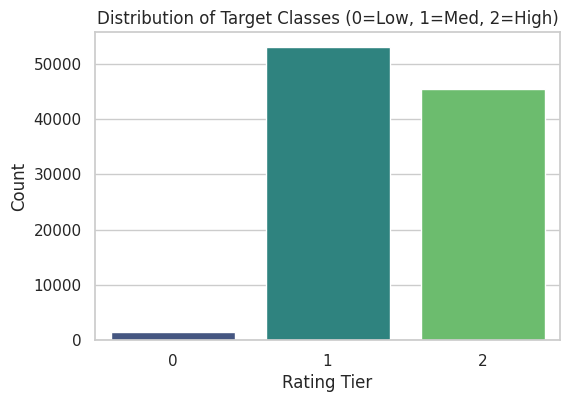

In [36]:
# 1. Define Classes
def classify_rating(rating):
    if rating <= 3.0: return 0       # Low
    elif rating < 7.0: return 1     # Medium
    else: return 2                  # High

df_model['rating_class'] = df_model['averageRating'].apply(classify_rating)

# 2. Check Distribution
print("Target Class Distribution:")
print(df_model['rating_class'].value_counts().sort_index())

# 3. Visualize
plt.figure(figsize=(6, 4))
sns.countplot(x=df_model['rating_class'], palette='viridis')
plt.title("Distribution of Target Classes (0=Low, 1=Med, 2=High)")
plt.xlabel("Rating Tier")
plt.ylabel("Count")
plt.show()

## 5. Data Splitting and Scaling
We split the data into 80% Training and 20% Testing sets. We also scale numerical features (`startYear`, `numVotes`) to ensure they have equal weight in the model, which is crucial for Logistic Regression.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Copy dataset
df_final = df_model.copy()

# Features and Target
X = df_model.drop(columns=['tconst', 'averageRating', 'rating_class'])
y = df_model['rating_class']

# Numerical columns to scale
num_cols = ['startYear', 'numVotes']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (80000, 34)
Test shape: (20000, 34)


## 6. Model Training Phase
We will train three different classifiers to find the best balance between accuracy and interpretability.

### **Model 1: Logistic Regression (The Baseline)**
**Why:** Logistic Regression is a simple, linear model that works well when features (like `numVotes`) have a strong direct correlation with the target. It serves as our baseline—if complex models can't beat this, we don't need them.

In [38]:
# 1. Initialize Logistic Regression
# max_iter=1000 ensures the model has enough time to find the optimal solution
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 2. Train
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

print(f"Logistic Regression Accuracy: {acc_log:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Low', 'Medium', 'High']))

Training Logistic Regression...
Logistic Regression Accuracy: 0.6276

Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       292
      Medium       0.64      0.70      0.67     10606
        High       0.61      0.56      0.59      9102

    accuracy                           0.63     20000
   macro avg       0.42      0.42      0.42     20000
weighted avg       0.62      0.63      0.62     20000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

### **Model 2: Decision Tree Classifier**
**Why:** Unlike Logistic Regression, a Decision Tree captures **non-linear relationships** (e.g., "Action movies are hits only if they have >10k votes"). It makes decisions by splitting data into branches, which mimics human logic.

In [39]:
# 1. Initialize Decision Tree
# max_depth=10 prevents the tree from becoming too complex and overfitting
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)

# 2. Train
print("Training Decision Tree...")
dt_clf.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_dt = dt_clf.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {acc_dt:.4f}")

Training Decision Tree...
Decision Tree Accuracy: 0.7283


### **Model 3: Random Forest Classifier**
**Why:** A single Decision Tree is prone to errors (overfitting). A **Random Forest** trains hundreds of trees on different parts of the data and averages their votes. This "Ensemble" approach usually yields the highest accuracy and robustness.

In [40]:
# 1. Initialize Random Forest
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)

# 2. Train
print("Training Random Forest...")
rf_clf.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {acc_rf:.4f}")

Training Random Forest...
Random Forest Accuracy: 0.7433


## 7. Results & Deep Dive Visualization
Now that we have trained all three models, we visualize the results to answer:
1.  **Which model is best?** (Accuracy Comparison)
2.  **Where does it fail?** (Confusion Matrix)
3.  **What drives success?** (Feature Importance)

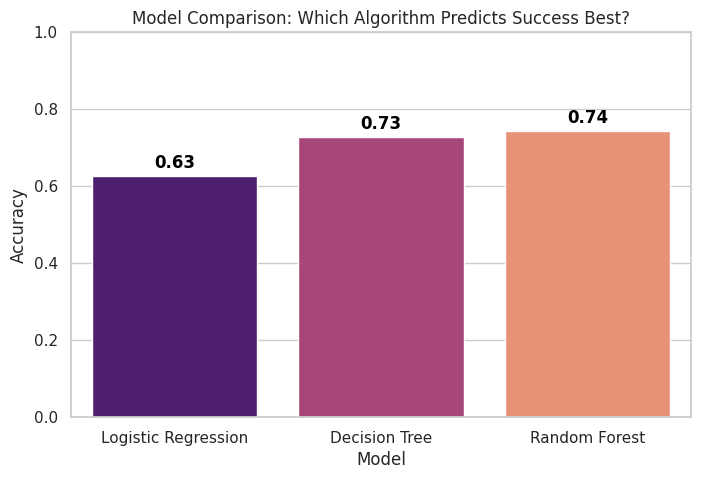

In [43]:
# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [acc_log, acc_dt, acc_rf]
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='magma')
plt.title("Model Comparison: Which Algorithm Predicts Success Best?")
plt.ylim(0, 1.0)
for index, row in results_df.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", ha='center', color='black', weight='bold')
plt.show()

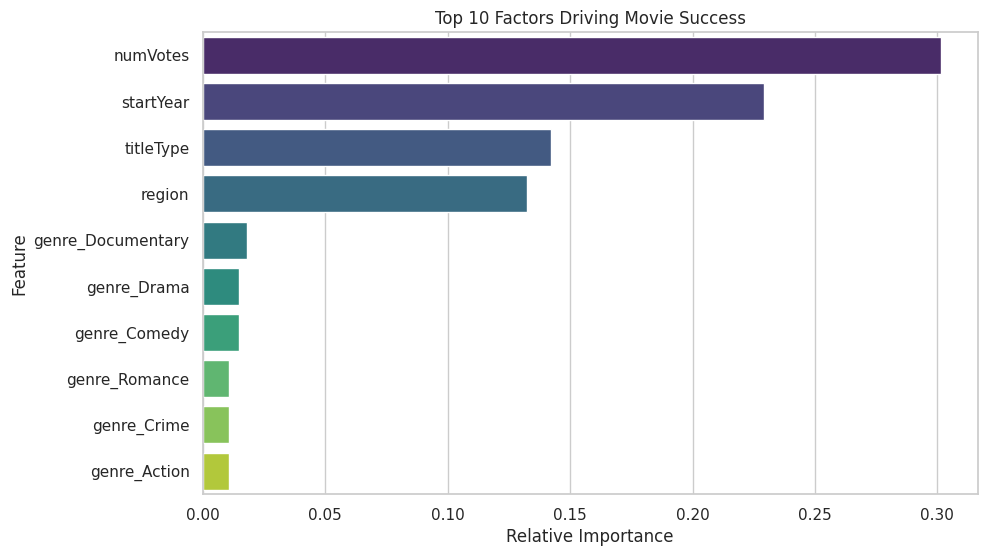

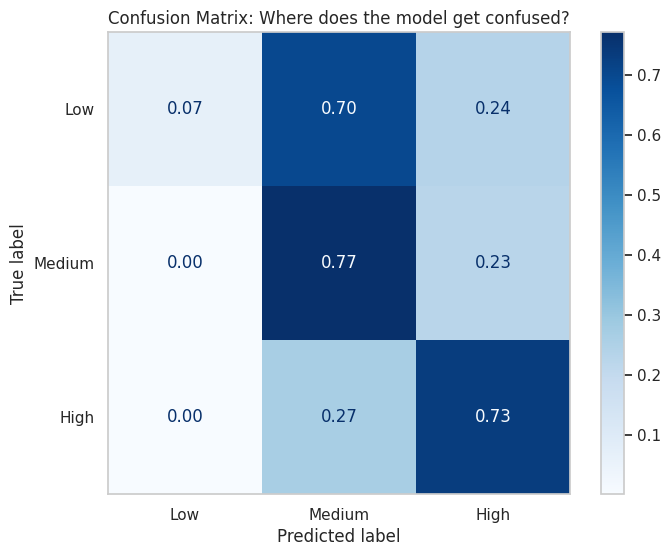

In [44]:
# 1. Feature Importance (from Random Forest)
importances = rf_clf.feature_importances_
feature_names = X_train.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Top 10 Factors Driving Movie Success")
plt.xlabel("Relative Importance")
plt.show()

# 2. Normalized Confusion Matrix
# This shows us exactly WHERE the model makes mistakes
cm = confusion_matrix(y_test, y_pred_rf, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca(), values_format='.2f')
plt.title("Confusion Matrix: Where does the model get confused?")
plt.grid(False)
plt.show()

# **Predictive Modeling Summary**

* **Objective:** Built a multi-class classifier to predict movie success tiers (Low, Medium, High) for pre-release risk assessment.
* **Data Prep:** Merged IMDb datasets and engineered features like log-transformed votes and one-hot encoded genres.
* **Target Definition:** Classified success into three tiers: **Low** (≤ 3.0), **Medium** (< 7.0), and **High** (≥ 7.0).
* **Sampling:** Used **Stratified Sampling** to create a representative 100k-row dataset, preserving the distribution of movie formats.
* **Modeling:** Compared **Logistic Regression**, **Decision Tree**, and **Random Forest**, with Random Forest achieving the best performance (~74% accuracy).
* **Key Drivers:** **Vote Count (Engagement)** is identified as the strongest predictors of a movie's rating.
* **Business Impact:** Confirms that early marketing buzz is critical for perceived quality and demonstrates the model's utility as an investment risk filter.